## **Import Library**

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter("ignore")

import os, shutil, re

import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from skimage.transform import rotate, AffineTransform, warp, resize
from skimage import img_as_ubyte
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import kagglehub
from roboflow import Roboflow
from PIL import ImageFile
import tensorflow.lite as tflite

ImageFile.LOAD_TRUNCATED_IMAGES = True
%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [5]:
print(tf.__version__)

2.19.0


## **Data Loading**

## **Load Data Roboflow (padi)**

In [ ]:
# Ganti API KEY pribadi
rf = Roboflow(api_key="tczUAD9ItEJzijsRq2t1") # API Key dari akunmu di roboflow
project = rf.workspace("capstone-bangkit-tmrzk").project("dataset-capstone-bangkit")
dataset = project.version(1).download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to DATASET-CAPSTONE-BANGKIT-1 in folder:: 100%|██████████████████████████████████████████████████████████████████████████████| 23006/23006 [03:03<00:00, 125.61it/s]


In [11]:
# Ganti dengan path tempat Anda mengunduh dataset
source_base_dir = './DATASET-CAPSTONE-BANGKIT-1' # Atau path ke folder utama dataset Anda
target_base_dir = './processed_dataset'

# Daftar 7 kelas dasar Anda
base_classes = [
    "BacterialBlight",
    "Blast",
    "Brownspot",
    "Healthy",
    "Leaf_Scald",
    "Tungro",
    "Unlabeled"
]

# Daftar folder split
splits = ['train', 'valid', 'test']

print(f"Mulai memproses. Sumber: '{source_base_dir}', Target: '{target_base_dir}'")

# 1. Buat struktur folder target (dengan split)
for split_name in splits:
    for class_name in base_classes:
        target_path = os.path.join(target_base_dir, split_name, class_name)
        os.makedirs(target_path, exist_ok=True)

print("Struktur folder target dibuat.")

# 2. Proses setiap split (train, valid, test)
for split_name in splits:
    current_split_path = os.path.join(source_base_dir, split_name)

    # Periksa apakah folder split ini ada
    if not os.path.isdir(current_split_path):
        print(f"Melewati: Folder split '{current_split_path}' tidak ditemukan.")
        continue

    print(f"\n--- Memproses Split: {split_name} ---")

    # Cari semua folder kelas di dalam folder split ini
    downloaded_class_folders = [
        f for f in os.listdir(current_split_path)
        if os.path.isdir(os.path.join(current_split_path, f))
    ]

    if not downloaded_class_folders:
        print(f"Tidak ada folder kelas ditemukan di '{current_split_path}'.")
        continue

    # 3. Proses setiap folder kelas (termasuk kombinasi)
    for folder_name in downloaded_class_folders:
        current_folder_path = os.path.join(current_split_path, folder_name)

        # Temukan semua kelas dasar yang relevan dari nama folder
        relevant_classes = []
        for base_class in base_classes:
            # Menggunakan ' ' + base_class + ' ' atau cek awal/akhir
            # untuk menghindari kecocokan parsial jika diperlukan,
            # tapi untuk nama-nama ini, 'in' mungkin cukup.
            # Kita pecah berdasarkan spasi untuk lebih akurat
            folder_parts = folder_name.split() # Pecah "BacterialBlight Blast" jadi ['BacterialBlight', 'Blast']
            if base_class in folder_parts:
                relevant_classes.append(base_class)
            elif base_class == folder_name: # Jika nama foldernya = nama kelas dasar
                relevant_classes.append(base_class)

        # Jika tidak ada kelas dasar yang cocok ATAU jika folder ini adalah kelas dasar tunggal
        # dan hanya ada 1 kelas, kita tangani
        if not relevant_classes:
            # Jika namanya adalah salah satu kelas dasar, tambahkan
            if folder_name in base_classes:
                relevant_classes.append(folder_name)
            else:
                 print(f"Melewati folder: {folder_name} (Tidak ada kelas dasar cocok)")
                 continue

        print(f"  Memproses {folder_name} -> Kelas: {relevant_classes}")

        # Cari semua file gambar di dalam folder ini
        try:
            for filename in os.listdir(current_folder_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    source_file_path = os.path.join(current_folder_path, filename)

                    # Salin gambar ke setiap folder kelas dasar yang relevan di split yang sama
                    for target_class in relevant_classes:
                        target_file_path = os.path.join(target_base_dir, split_name, target_class, filename)

                        if not os.path.exists(target_file_path):
                             shutil.copy(source_file_path, target_file_path)
                        # else:
                        #    print(f"    File {filename} sudah ada di {target_class}, dilewati.")
        except Exception as e:
            print(f"    Error saat memproses folder {folder_name}: {e}")


print("\n--- Proses penyalinan selesai. ---")
print(f"Data yang telah diorganisir ada di folder: {target_base_dir}")
print("Pastikan untuk memeriksa isinya!")

Mulai memproses. Sumber: './DATASET-CAPSTONE-BANGKIT-1', Target: './processed_dataset'
Struktur folder target dibuat.

--- Memproses Split: train ---
  Memproses BacterialBlight -> Kelas: ['BacterialBlight']
  Memproses BacterialBlight Blast -> Kelas: ['BacterialBlight', 'Blast']
  Memproses BacterialBlight Blast Tungro -> Kelas: ['BacterialBlight', 'Blast', 'Tungro']
  Memproses BacterialBlight Leaf_Scald -> Kelas: ['BacterialBlight', 'Leaf_Scald']
  Memproses BacterialBlight Tungro -> Kelas: ['BacterialBlight', 'Tungro']
  Memproses Blast -> Kelas: ['Blast']
  Memproses Blast Brownspot -> Kelas: ['Blast', 'Brownspot']
  Memproses Blast Tungro -> Kelas: ['Blast', 'Tungro']
  Memproses Brownspot -> Kelas: ['Brownspot']
  Memproses Brownspot Leaf_Scald -> Kelas: ['Brownspot', 'Leaf_Scald']
  Memproses Brownspot Tungro -> Kelas: ['Brownspot', 'Tungro']
  Memproses Healthy -> Kelas: ['Healthy']
  Memproses Leaf_Scald -> Kelas: ['Leaf_Scald']
  Memproses Tungro -> Kelas: ['Tungro']

--- Me

## **Data Preparation**

In [16]:
dataset_path = Path("./processed_dataset")

splits = ["train", "valid", "test"] # Gunakan 'valid', bukan 'val'
classes = ["BacterialBlight", "Blast", "Brownspot", "Healthy", "Leaf_Scald", "Tungro"]

# Loop melalui setiap split (train, valid, test)
for split_name in splits:
    split_path = dataset_path / split_name
    
    # Periksa apakah folder split ada
    if not split_path.exists():
        print(f"!! ERROR: Split folder not found - {split_path}")
        continue # Lanjut ke split berikutnya jika tidak ada

    print(f"\nVerifying contents of {split_path}:")

    # Loop melalui setiap kelas di dalam split
    for class_name in classes:
        class_path = split_path / class_name

        # Periksa apakah folder kelas ada
        if not class_path.exists():
            print(f"  Warning: Class folder not found - {class_path}")
        else:
            # Hitung jumlah file (opsional, tapi berguna)
            try:
                num_files = len([item for item in class_path.iterdir() if item.is_file()])
                print(f"  OK: Found {class_path.name} with {num_files} files.")
            except Exception as e:
                 print(f"  Error reading {class_path}: {e}")
print("\nVerification complete.")


Verifying contents of processed_dataset/train:
  OK: Found BacterialBlight with 4407 files.
  OK: Found Blast with 5523 files.
  OK: Found Brownspot with 3594 files.
  OK: Found Healthy with 2580 files.
  OK: Found Leaf_Scald with 2595 files.
  OK: Found Tungro with 2382 files.

Verifying contents of processed_dataset/valid:
  OK: Found BacterialBlight with 219 files.
  OK: Found Blast with 221 files.
  OK: Found Brownspot with 227 files.
  OK: Found Healthy with 173 files.
  OK: Found Leaf_Scald with 214 files.
  OK: Found Tungro with 206 files.

Verifying contents of processed_dataset/test:
  OK: Found BacterialBlight with 271 files.
  OK: Found Blast with 136 files.
  OK: Found Brownspot with 188 files.
  OK: Found Healthy with 104 files.
  OK: Found Leaf_Scald with 150 files.
  OK: Found Tungro with 107 files.

Verification complete.


Found 3 splits: test, train, valid
Found 7 classes in total.

📁 Class: BacterialBlight (4897 images)



📁 Class: Blast (5880 images)



📁 Class: Brownspot (4009 images)


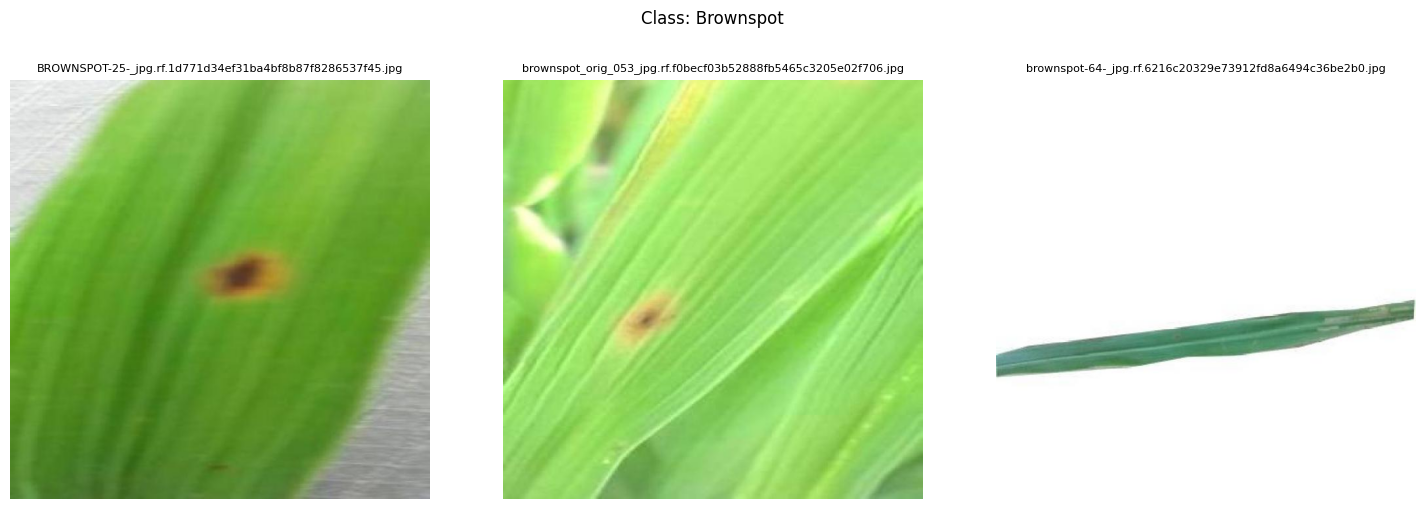


📁 Class: Healthy (2857 images)


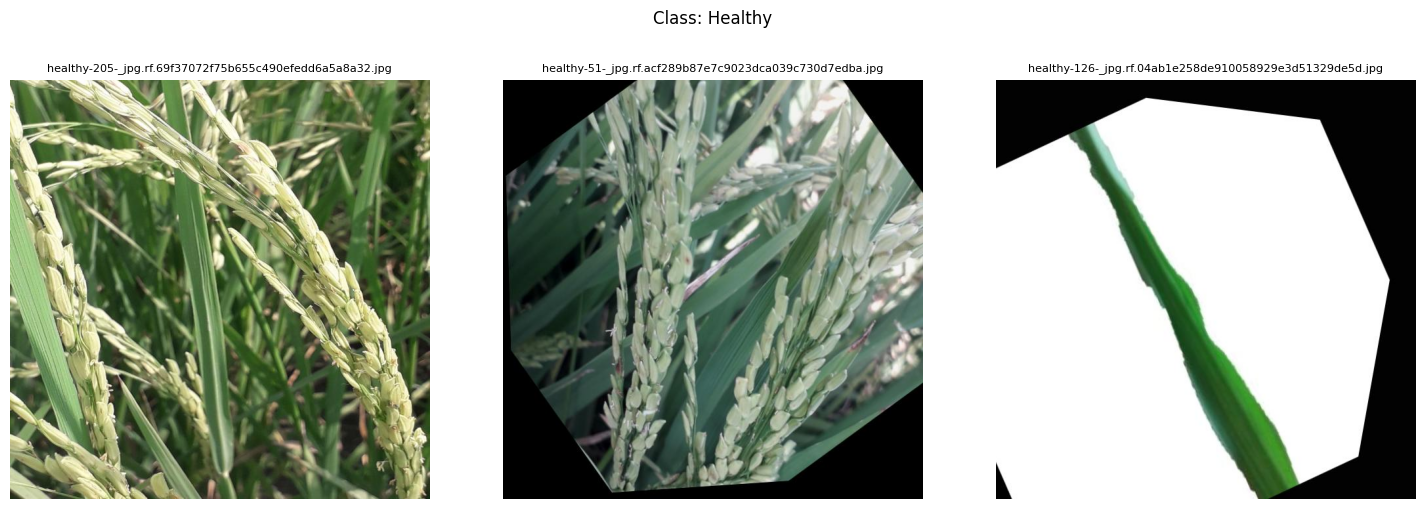


📁 Class: Leaf_Scald (2959 images)


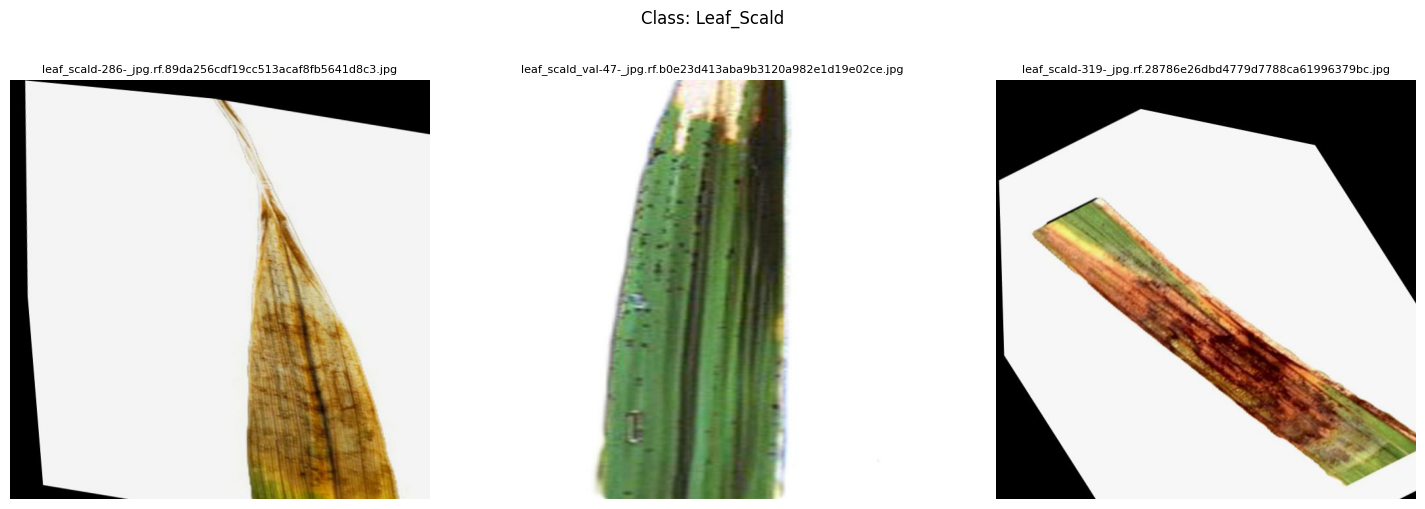


📁 Class: Tungro (2695 images)


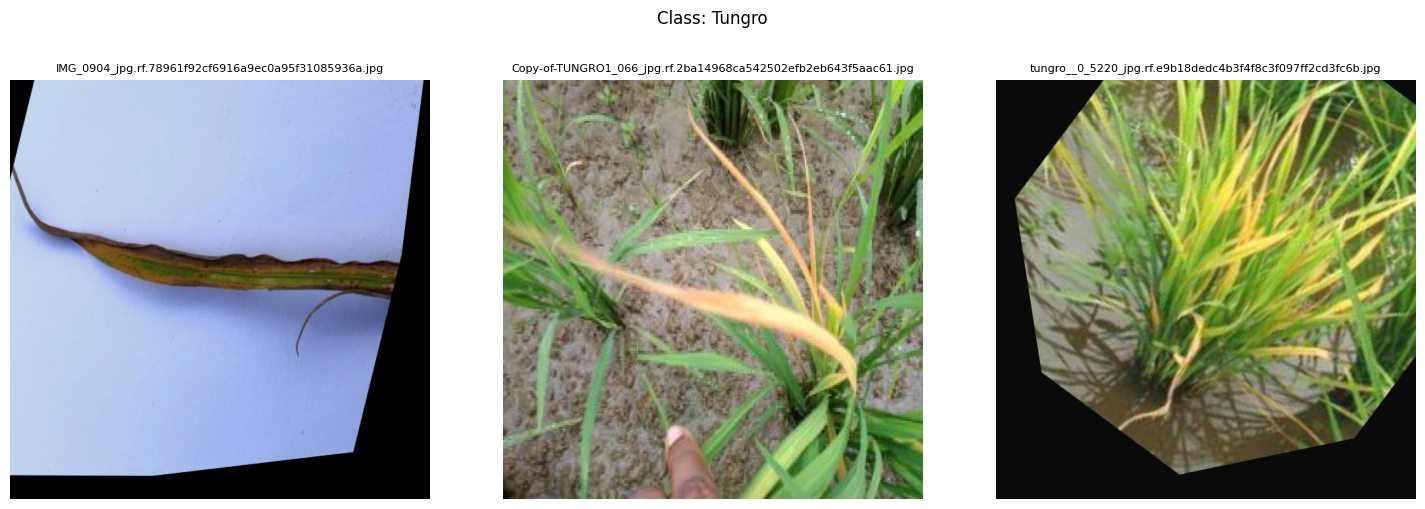


📁 Class: Unlabeled (0 images)
⚠️ No images found for this class


In [18]:
sub_dataset = Path("processed_dataset")

# Fungsi yang diperbaiki untuk menampilkan gambar
def show_samples_per_class(root_path, samples_per_class=3):

    classes_images = {}
    splits_found = []

    # 1. Telusuri folder split (train, valid, test)
    for split_folder in root_path.iterdir():
        if split_folder.is_dir():
            splits_found.append(split_folder.name)
            # 2. Telusuri folder kelas di dalam split
            for class_folder in split_folder.iterdir():
                if class_folder.is_dir():
                    class_name = class_folder.name
                    
                    # Inisialisasi list jika kelas ini baru pertama kali ditemukan
                    if class_name not in classes_images:
                        classes_images[class_name] = []

                    # 3. Kumpulkan semua path gambar di kelas ini
                    for img_file in class_folder.glob('*'):
                        if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                            classes_images[class_name].append(img_file)

    print(f"Found {len(splits_found)} splits: {', '.join(splits_found)}")
    print(f"Found {len(classes_images)} classes in total.")

    # 4. Tampilkan 3 gambar acak per kelas (dari semua split digabung)
    for class_name, img_paths in classes_images.items():
        print(f"\n📁 Class: {class_name} ({len(img_paths)} images)")

        if len(img_paths) == 0:
            print("⚠️ No images found for this class")
            continue

        # Ambil sampel acak
        samples = random.sample(img_paths, min(samples_per_class, len(img_paths)))

        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Class: {class_name}", y=1.02) # Sesuaikan y agar tidak tumpang tindih

        for i, img_path in enumerate(samples, 1):
            plt.subplot(1, samples_per_class, i)
            try:
                img = mpimg.imread(img_path)
                plt.imshow(img)
                # Tampilkan nama file saja, bukan path lengkap
                plt.title(os.path.basename(img_path), fontsize=8) # Perkecil font jika perlu
                plt.axis('off')
            except Exception as e:
                print(f"⚠️ Error loading {img_path}: {e}")
                # Jangan tutup plot, biarkan subplot lain tampil
                plt.title(f"Error: {os.path.basename(img_path)}", fontsize=8, color='red')
                plt.axis('off')

        plt.tight_layout(pad=1.5) # Beri sedikit padding
        plt.show()

# --- Pastikan Anda sudah mengimpor library ---
# import random
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import os
# from pathlib import Path

# Tampilkan 3 gambar per kelas
show_samples_per_class(sub_dataset, samples_per_class=3)

In [20]:
print("\n🔍 Directory structure verification:")
if sub_dataset.exists() and sub_dataset.is_dir():
    print(f"Isi dari {sub_dataset}:")
    
    # 1. Loop melalui folder level 1 (test, train, valid)
    #    Menggunakan sorted() agar outputnya terurut (test, train, valid)
    for split_folder in sorted(sub_dataset.iterdir()):
        if split_folder.is_dir():
            # Tampilkan nama folder split
            print(f" - {split_folder.name} (folder)")
            
            # 2. Loop melalui folder level 2 (kelas penyakit) di dalam split_folder
            try:
                # Menggunakan sorted() lagi agar nama penyakit terurut
                for class_folder in sorted(split_folder.iterdir()):
                    # Tampilkan nama folder kelas dengan indentasi
                    if class_folder.is_dir():
                        print(f"   - {class_folder.name} (folder)")
                    else:
                        # Jika ada file (seharusnya tidak), tampilkan juga
                        print(f"   - {class_folder.name} (file)") 
            except Exception as e:
                print(f"   Error saat membaca {split_folder.name}: {e}")
        
        elif split_folder.is_file():
             # Jika ada file di level utama (seharusnya tidak), tampilkan
             print(f" - {split_folder.name} (file)")

else:
    print(f"Direktori {sub_dataset} tidak ditemukan atau bukan direktori.")


🔍 Directory structure verification:
Isi dari processed_dataset:
 - test (folder)
   - BacterialBlight (folder)
   - Blast (folder)
   - Brownspot (folder)
   - Healthy (folder)
   - Leaf_Scald (folder)
   - Tungro (folder)
   - Unlabeled (folder)
 - train (folder)
   - BacterialBlight (folder)
   - Blast (folder)
   - Brownspot (folder)
   - Healthy (folder)
   - Leaf_Scald (folder)
   - Tungro (folder)
   - Unlabeled (folder)
 - valid (folder)
   - BacterialBlight (folder)
   - Blast (folder)
   - Brownspot (folder)
   - Healthy (folder)
   - Leaf_Scald (folder)
   - Tungro (folder)
   - Unlabeled (folder)


## **Exploratory Data**

In [22]:
# Inisialisasi list untuk menyimpan data
data = []

print("Mulai memproses dataset untuk membuat DataFrame...")

# 1. Loop melalui folder split (train, valid, test)
for split_folder in sub_dataset.iterdir():
    if split_folder.is_dir():
        split_name = split_folder.name  # Ambil nama split (train/valid/test)

        # 2. Loop melalui folder kelas di dalam split
        for class_folder in split_folder.iterdir():
            if class_folder.is_dir():
                class_name = class_folder.name # Ambil nama kelas (BacterialBlight, dll)

                # 3. Loop melalui semua file gambar di dalam folder kelas
                for img_file in class_folder.glob('*'):
                    if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        try:
                            # Buka gambar untuk mendapatkan resolusi
                            with Image.open(img_file) as img:
                                width, height = img.size

                            # Tambahkan data ke list, termasuk nama split
                            data.append({
                                'filename': img_file.name,
                                'filepath': str(img_file),
                                'label': class_name,
                                'split': split_name, # Tambahkan kolom split
                                'width': width,
                                'height': height,
                                'resolution': f"{width}x{height}"
                            })
                        except Exception as e:
                            print(f"⚠️ Error processing {img_file}: {str(e)}")
                            continue # Lanjut ke file berikutnya jika ada error

print(f"Selesai memproses. Ditemukan {len(data)} gambar.")

# --- Sekarang buat DataFrame HANYA JIKA data tidak kosong ---
if data:
    # Buat DataFrame
    df_original = pd.DataFrame(data)

    # Tambahkan kolom tambahan untuk analisis
    df_original['image_size'] = df_original['filepath'].apply(lambda x: os.path.getsize(x)) # in bytes
    df_original['extension'] = df_original['filename'].apply(lambda x: os.path.splitext(x)[1].lower())

    # Tampilkan beberapa baris pertama dan info DataFrame
    print("\nDataFrame berhasil dibuat:")
    print(df_original.head())
    print("\nInfo DataFrame:")
    df_original.info()
else:
    print("\n!! Tidak ada data gambar yang ditemukan. DataFrame tidak dapat dibuat.")

Mulai memproses dataset untuk membuat DataFrame...
Selesai memproses. Ditemukan 23297 gambar.

DataFrame berhasil dibuat:
                                            filename  \
0  2-10-_jpg.rf.e19a6654fef07897446093417e2aded1.jpg   
1  2-19-_jpg.rf.5ceeb2a42444628b8afb0e2b879db468.jpg   
2  2-20-_jpg.rf.923f4bcfbab57c40617ed4c4d33012c9.jpg   
3  2-25-_jpg.rf.d6eb0d8bc1567571330110d5bfc5282b.jpg   
4  2-44-_jpg.rf.222359bfee013c294c422e5a888dabfd.jpg   

                                            filepath            label split  \
0  processed_dataset/test/BacterialBlight/2-10-_j...  BacterialBlight  test   
1  processed_dataset/test/BacterialBlight/2-19-_j...  BacterialBlight  test   
2  processed_dataset/test/BacterialBlight/2-20-_j...  BacterialBlight  test   
3  processed_dataset/test/BacterialBlight/2-25-_j...  BacterialBlight  test   
4  processed_dataset/test/BacterialBlight/2-44-_j...  BacterialBlight  test   

   width  height resolution  image_size extension  
0    640     6

In [23]:
# Tampilkan info dasar
print(f"📊 Total images: {len(df_original)}")
print(f"🏷️ Unique labels: {df_original['label'].nunique()}")
print("\n🔍 Sample data with resolution info:")
display(df_original.head())

# Analisis distribusi kelas dan resolusi
print("\n📈 Class distribution:")
display(df_original['label'].value_counts())

print("\n🖼️ Common resolutions:")
display(df_original['resolution'].value_counts().head(10))

# Analisis statistik resolusi
print("\n📏 Resolution statistics:")
print(f"Average width: {df_original['width'].mean():.0f} px")
print(f"Average height: {df_original['height'].mean():.0f} px")
print(f"\nMinimum resolution: {df_original['width'].min()}x{df_original['height'].min()}")
print(f"Maximum resolution: {df_original['width'].max()}x{df_original['height'].max()}")

📊 Total images: 23297
🏷️ Unique labels: 6

🔍 Sample data with resolution info:


filename  \
0  2-10-_jpg.rf.e19a6654fef07897446093417e2aded1.jpg   
1  2-19-_jpg.rf.5ceeb2a42444628b8afb0e2b879db468.jpg   
2  2-20-_jpg.rf.923f4bcfbab57c40617ed4c4d33012c9.jpg   
3  2-25-_jpg.rf.d6eb0d8bc1567571330110d5bfc5282b.jpg   
4  2-44-_jpg.rf.222359bfee013c294c422e5a888dabfd.jpg   

                                            filepath            label split  \
0  processed_dataset/test/BacterialBlight/2-10-_j...  BacterialBlight  test   
1  processed_dataset/test/BacterialBlight/2-19-_j...  BacterialBlight  test   
2  processed_dataset/test/BacterialBlight/2-20-_j...  BacterialBlight  test   
3  processed_dataset/test/BacterialBlight/2-25-_j...  BacterialBlight  test   
4  processed_dataset/test/BacterialBlight/2-44-_j...  BacterialBlight  test   

   width  height resolution  image_size extension  
0    640     640    640x640       34565      .jpg  
1    640     640    640x640       34038      .jpg  
2    640     640    640x640       46070      .jpg  
3    640     640    640x640       32448      .jpg  
4    640     640    640x640       45112      .jpg


📈 Class distribution:


label
Blast              5880
BacterialBlight    4897
Brownspot          4009
Leaf_Scald         2959
Healthy            2857
Tungro             2695
Name: count, dtype: int64


🖼️ Common resolutions:


resolution
640x640    23297
Name: count, dtype: int64


📏 Resolution statistics:
Average width: 640 px
Average height: 640 px

Minimum resolution: 640x640
Maximum resolution: 640x640


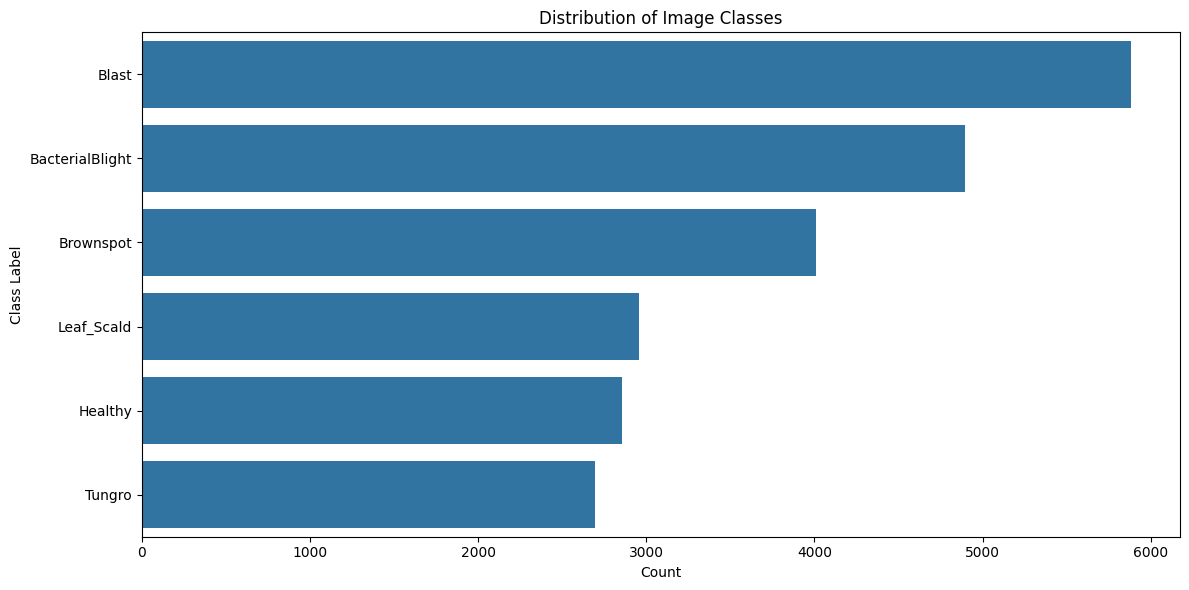

In [24]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_original, y='label', order=df_original['label'].value_counts().index)
plt.title('Distribution of Image Classes')
plt.xlabel('Count')
plt.ylabel('Class Label')
plt.tight_layout()
plt.show()

## **Data Augmentation**

In [25]:
# Konfigurasi augmentasi
TARGET_SIZE = (224, 224)

def preprocess_image(img):
    """Fungsi preprocessing standar dengan penanganan format gambar yang lebih baik"""
    # Konversi ke uint8 jika diperlukan
    if img.dtype != np.uint8:
        if img.dtype == np.float64:
            img = (img * 255).astype(np.uint8)
        else:
            img = img_as_ubyte(img)

    # Konversi ke 3 channel jika grayscale
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # Jika gambar RGBA
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, TARGET_SIZE)
    return img

# Optimasi fungsi transformasi
def optimized_rotation(img, angle=None, clockwise=False):
    try:
        img = preprocess_image(img)
        angle = angle if angle is not None else random.randint(5, 180)
        angle = -angle if clockwise else angle
        return rotate(img, angle, mode='edge')
    except Exception as e:
        print(f"Rotation error: {str(e)}")
        return img

def optimized_flip(img, direction='up_down'):
    try:
        img = preprocess_image(img)
        if direction == 'up_down':
            return np.flipud(img)
        elif direction == 'left_right':
            return np.fliplr(img)
        return img
    except Exception as e:
        print(f"Flip error: {str(e)}")
        return img

def optimized_brightness(img, gamma_range=(0.5, 1.5)):
    try:
        img = preprocess_image(img)
        gamma = random.uniform(*gamma_range)
        return adjust_gamma(img, gamma=gamma)
    except Exception as e:
        print(f"Brightness error: {str(e)}")
        return img

def optimized_blur(img, kernel_size=None):
    try:
        img = preprocess_image(img)
        kernel_size = kernel_size or random.choice([(3,3), (5,5), (7,7)])
        return cv2.GaussianBlur(img, kernel_size, 0)
    except Exception as e:
        print(f"Blur error: {str(e)}")
        return img

def optimized_geometric_transform(img, transform_type='shear'):
    try:
        img = preprocess_image(img)
        if transform_type == 'shear':
            transform = AffineTransform(shear=random.uniform(-0.2, 0.2))
        elif transform_type == 'warp':
            transform = AffineTransform(translation=(random.uniform(-20, 20), random.uniform(-20, 20)))
        return warp(img, transform, mode='edge')
    except Exception as e:
        print(f"Transform error: {str(e)}")
        return img

In [26]:
transformations = {
    'rotate_ccw': partial(optimized_rotation, clockwise=False),
    'rotate_cw': partial(optimized_rotation, clockwise=True),
    'flip_ud': partial(optimized_flip, direction='up_down'),
    'flip_lr': partial(optimized_flip, direction='left_right'),
    'brightness': optimized_brightness,
    'blur': optimized_blur,
    'shear': partial(optimized_geometric_transform, transform_type='shear'),
    'warp': partial(optimized_geometric_transform, transform_type='warp')
}

In [27]:
def load_image_safely(img_path):
    """Memuat gambar dengan penanganan format yang aman"""
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")

        # Konversi ke uint8 jika diperlukan
        if img.dtype != np.uint8:
            img = img_as_ubyte(img)

        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {str(e)}")
        return None

def augment_class(class_path, save_path, target_count, max_transforms=3):
    """
    Augmentasi gambar dalam satu kelas dengan penanganan error yang lebih baik
    """
    os.makedirs(save_path, exist_ok=True)
    existing_images = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(existing_images)

    if current_count == 0:
        print(f"No valid images found in {class_path}")
        return

    augment_count = max(0, target_count - current_count)
    augmented = 0

    with tqdm(total=augment_count, desc=f"Augmenting {os.path.basename(class_path)}") as pbar:
        while augmented < augment_count:
            img_file = random.choice(existing_images)
            img_path = os.path.join(class_path, img_file)

            img = load_image_safely(img_path)
            if img is None:
                continue

            try:
                # Terapkan 1-3 transformasi acak
                transforms_to_apply = random.randint(1, max_transforms)
                transformed_img = img.copy()

                for _ in range(transforms_to_apply):
                    transform_name = random.choice(list(transformations.keys()))
                    transformed_img = transformations[transform_name](transformed_img)
                    if transformed_img is None:
                        raise ValueError("Transformation returned None")

                # Pastikan format output benar
                if transformed_img.dtype != np.uint8:
                    transformed_img = img_as_ubyte(transformed_img)

                # Simpan gambar hasil augmentasi
                base_name = os.path.splitext(img_file)[0]
                save_name = f"aug_{base_name}_{augmented}.jpg"
                save_full_path = os.path.join(save_path, save_name)

                # Konversi ke BGR untuk penyimpanan OpenCV
                if len(transformed_img.shape) == 3 and transformed_img.shape[2] == 3:
                    transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR)

                cv2.imwrite(save_full_path, transformed_img)
                augmented += 1
                pbar.update(1)

            except Exception as e:
                print(f"\nError processing image {img_path}: {str(e)}")
                continue

def balance_dataset(dataset_path, augmented_path, balance_method='max'):
    """
    Balance semua kelas dalam dataset
    Args:
        balance_method: 'max' untuk match kelas terbanyak,
                       atau angka untuk target tetap
    """
    classes = [d for d in os.listdir(dataset_path)
               if os.path.isdir(os.path.join(dataset_path, d))]

    if not classes:
        raise ValueError("No classes found in dataset directory")

    # Hitung jumlah gambar per kelas
    class_counts = {}
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[cls] = count

    # Tentukan target count
    if isinstance(balance_method, int):
        target_count = balance_method
    else:  # 'max'
        target_count = max(class_counts.values())

    print("\nDataset Balance Summary:")
    print(f"{'Class':<20} {'Original':<10} {'Augmented Needed':<15}")
    for cls, count in class_counts.items():
        print(f"{cls:<20} {count:<10} {max(0, target_count-count):<15}")

    # Proses augmentasi untuk setiap kelas
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        save_path = os.path.join(augmented_path, cls)
        augment_class(cls_path, save_path, target_count)

    print("\nAugmentation completed successfully!")

In [31]:
if __name__ == "__main__":
    # Path dasar
    base_dataset_path = Path("processed_dataset")
    base_augmented_path = Path("augmented_balanced")

    # Split yang akan diproses
    splits_to_process = ["train", "valid", "test"] 

    print("Starting dataset balancing process...")

    # Loop melalui setiap split
    for split_name in splits_to_process:
        print(f"\n=======================================")
        print(f"Processing Split: {split_name}")
        print(f"=======================================")

        original_split_path = base_dataset_path / split_name
        augmented_split_path = base_augmented_path / split_name

        # Validasi path sumber untuk split ini
        if not original_split_path.exists() or not original_split_path.is_dir():
            print(f"⚠️ Warning: Source split not found or not a directory: {original_split_path}. Skipping.")
            continue

        # Buat folder output untuk split ini jika belum ada
        augmented_split_path.mkdir(parents=True, exist_ok=True)

        print(f"Copying original images from {original_split_path} to {augmented_split_path}...")
        try:
             # Gunakan shutil.copytree dengan dirs_exist_ok=True (Python 3.8+)
             shutil.copytree(original_split_path, augmented_split_path, dirs_exist_ok=True)
        except Exception as e:
             print(f"❌ Error copying original files for {split_name}: {e}")
             continue
        try:
            balance_dataset(str(augmented_split_path), str(augmented_split_path), balance_method='max')
        except Exception as e:
            print(f"❌ An error occurred during balancing for {split_name}: {e}")

    print("\n\n✅ Overall dataset processing completed!")

Starting dataset balancing process...

Processing Split: train
Copying original images from processed_dataset/train to augmented_balanced/train...

Dataset Balance Summary:
Class                Original   Augmented Needed
BacterialBlight      4407       1116           
Blast                5523       0              
Brownspot            3594       1929           
Healthy              2580       2943           
Leaf_Scald           2595       2928           
Tungro               2382       3141           
Unlabeled            0          5523           


Augmenting BacterialBlight: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1116/1116 [00:31<00:00, 34.91it/s]
Augmenting Blast: 0it [00:00, ?it/s]
Augmenting Tungro: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3141/3141 [01:22<00:00, 37.91it/s]


No valid images found in augmented_balanced/train/Unlabeled

Augmentation completed successfully!

Processing Split: valid
Copying original images from processed_dataset/valid to augmented_balanced/valid...

Dataset Balance Summary:
Class                Original   Augmented Needed
BacterialBlight      219        8              
Blast                221        6              
Brownspot            227        0              
Healthy              173        54             
Leaf_Scald           214        13             
Tungro               206        21             
Unlabeled            0          227            


Augmenting Blast: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 41.81it/s]
Augmenting Brownspot: 0it [00:00, ?it/s]
Augmenting Tungro: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 41.90it/s]


No valid images found in augmented_balanced/valid/Unlabeled

Augmentation completed successfully!

Processing Split: test
Copying original images from processed_dataset/test to augmented_balanced/test...

Dataset Balance Summary:
Class                Original   Augmented Needed
BacterialBlight      271        0              
Blast                136        135            
Brownspot            188        83             
Healthy              104        167            
Leaf_Scald           150        121            
Tungro               107        164            
Unlabeled            0          271            


Augmenting BacterialBlight: 0it [00:00, ?it/s]
Augmenting Tungro: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:03<00:00, 41.55it/s]


No valid images found in augmented_balanced/test/Unlabeled

Augmentation completed successfully!


✅ Overall dataset processing completed!


## **Merging Dataset**

In [33]:
# Path ke dataset
original_path = Path("processed_dataset")
augmented_path = Path("augmented_balanced")
merged_path = Path("merged_dataset")

# Buat folder merged jika belum ada
merged_path.mkdir(parents=True, exist_ok=True)

# Inisialisasi list untuk menyimpan data DataFrame nanti
data = []

# Daftar split yang akan diproses
splits = ["train", "valid", "test"]

print("Starting dataset merging process...")

# --- Loop melalui Split ---
for split_name in tqdm(splits, desc="Processing Splits"):
    original_split_path = original_path / split_name
    augmented_split_path = augmented_path / split_name
    merged_split_path = merged_path / split_name

    # Buat folder split di merged_path
    merged_split_path.mkdir(exist_ok=True)

    # Periksa apakah folder split asli ada
    if not original_split_path.exists():
        print(f"⚠️ Warning: Original split path not found: {original_split_path}. Skipping.")
        continue

    # --- Loop melalui Kelas di dalam Split ---
    class_names = [d.name for d in original_split_path.iterdir() if d.is_dir()]
    
    for class_name in tqdm(class_names, desc=f"Merging {split_name}", leave=False):
        
        class_original_path = original_split_path / class_name
        class_augmented_path = augmented_split_path / class_name
        class_merged_path = merged_split_path / class_name

        # Buat folder kelas di merged_path
        class_merged_path.mkdir(exist_ok=True)

        # Fungsi untuk menyalin dan mengumpulkan data
        def copy_and_collect(src_folder, dest_folder):
            if src_folder.exists():
                for img_file in src_folder.glob('*'):
                    if img_file.is_file() and img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        dest_file = dest_folder / img_file.name
                        if not dest_file.exists():
                            shutil.copy(img_file, dest_file)
                        
                        # Tambahkan ke data HANYA jika belum ada (untuk menghindari duplikasi di list)
                        if dest_file.exists() and str(dest_file) not in [d['filepath'] for d in data]:
                            try:
                                with Image.open(dest_file) as img:
                                    width, height = img.size
                                data.append({
                                    'filename': dest_file.name,
                                    'filepath': str(dest_file),
                                    'label': class_name,
                                    'split': split_name,
                                    'width': width,
                                    'height': height,
                                    'resolution': f"{width}x{height}",
                                    'image_size': os.path.getsize(dest_file),
                                    'extension': dest_file.suffix.lower()
                                })
                            except Exception as e:
                                print(f"⚠️ Error reading metadata for {dest_file}: {e}")

        # Salin dari original_path dan augmented_path
        copy_and_collect(class_original_path, class_merged_path)
        copy_and_collect(class_augmented_path, class_merged_path)


print("\n✅ Merging process completed.")

# --- Buat DataFrame dari Merged Dataset ---
if data:
    print("\nCreating DataFrame from merged dataset...")
    df_merged = pd.DataFrame(data)
    print("DataFrame created successfully:")
    print(df_merged.head())
    print("\nInfo DataFrame:")
    df_merged.info()
else:
    print("\n!! No data collected. DataFrame cannot be created.")

Starting dataset merging process...


Processing Splits: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [29:43<00:00, 594.43s/it]



✅ Merging process completed.

Creating DataFrame from merged dataset...
DataFrame created successfully:
                                            filename  \
0   2-1-_jpg.rf.3f86d2aa4bf1eb3463259ae561b26ccb.jpg   
1   2-1-_jpg.rf.5336cea2d0a97d234deeb74e8d7f251f.jpg   
2   2-1-_jpg.rf.b5bc9aaf1d58c1710c2ef7e83c72fd1c.jpg   
3  2-11-_jpg.rf.ab472015212e4b517856ccd586d31957.jpg   
4  2-11-_jpg.rf.ab4f2339afdb869854b9bb2416ff2af7.jpg   

                                            filepath            label  split  \
0  merged_dataset/train/BacterialBlight/2-1-_jpg....  BacterialBlight  train   
1  merged_dataset/train/BacterialBlight/2-1-_jpg....  BacterialBlight  train   
2  merged_dataset/train/BacterialBlight/2-1-_jpg....  BacterialBlight  train   
3  merged_dataset/train/BacterialBlight/2-11-_jpg...  BacterialBlight  train   
4  merged_dataset/train/BacterialBlight/2-11-_jpg...  BacterialBlight  train   

   width  height resolution  image_size extension  
0    640     640    640x6

In [34]:

def get_image_metadata(img_path):
    try:
        with Image.open(img_path) as img:
            width, height = img.size
        return {
            'width': width,
            'height': height,
            'resolution': f"{width}x{height}",
            'image_size': os.path.getsize(img_path) # Ukuran file dalam bytes
        }
    except Exception as e:
        print(f"⚠️ Error processing metadata for {img_path}: {str(e)}")
        return None

# Path ke dataset yang sudah digabung
merged_path = Path("merged_dataset") # Pastikan ini adalah path yang benar

# Inisialisasi list untuk menyimpan data
merged_data = []

print("Mulai memproses dataset yang sudah digabung untuk membuat DataFrame...")

# 1. Loop melalui folder split (train, valid, test)
for split_folder in tqdm(merged_path.iterdir(), desc="Processing Splits"):
    if split_folder.is_dir():
        split_name = split_folder.name  # Ambil nama split

        # 2. Loop melalui folder kelas di dalam split
        for class_folder in tqdm(split_folder.iterdir(), desc=f"Processing Classes in {split_name}", leave=False):
            if class_folder.is_dir():
                class_name = class_folder.name  # Ambil nama kelas

                # 3. Loop melalui semua file gambar di dalam folder kelas
                for img_file in class_folder.glob('*'):
                    if img_file.is_file() and img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        metadata = get_image_metadata(img_file)
                        if metadata:
                            # Tentukan apakah gambar asli atau hasil augmentasi
                            source = 'original' if 'aug_' not in img_file.name else 'augmented'
                            
                            merged_data.append({
                                'filename': img_file.name,
                                'filepath': str(img_file),
                                'label': class_name,
                                'split': split_name,  # Tambahkan informasi split
                                # Logika disease_type mungkin perlu disesuaikan jika nama kelas Anda berbeda
                                # Untuk dataset padi, ini mungkin tidak terlalu relevan jika 'label' sudah cukup
                                'disease_type': class_name, # Atau logika spesifik Anda
                                'source': source,
                                **metadata  # Unpack dictionary metadata
                            })

print(f"\nSelesai memproses. Ditemukan {len(merged_data)} entri gambar.")

# --- Buat DataFrame HANYA JIKA merged_data tidak kosong ---
if merged_data:
    df_merged = pd.DataFrame(merged_data)
    
    # Tambahkan kolom ekstensi jika belum ada dari metadata (get_image_metadata tidak menyertakannya)
    if 'extension' not in df_merged.columns:
        df_merged['extension'] = df_merged['filename'].apply(lambda x: os.path.splitext(x)[1].lower())

    # Tampilkan info
    print(f"\n📊 Merged Dataset Summary:")
    print(f"Total images: {len(df_merged)}")
    print(f"Unique labels: {df_merged['label'].nunique()}")
    print(f"Images per split:\n{df_merged['split'].value_counts()}")

    print("\n🔍 Sample data (5 baris pertama):")
    # Menggunakan print untuk notebook/script, display() lebih untuk Jupyter
    print(df_merged.head())

    print("\n📈 Class distribution (berdasarkan 'label'):")
    print(df_merged['label'].value_counts())
    
    print("\n📊 Source distribution (original vs augmented):")
    print(df_merged['source'].value_counts())

    print("\n🖼️ Top 10 Resolution distribution:")
    print(df_merged['resolution'].value_counts().head(10))

    print("\nInfo DataFrame Lengkap:")
    df_merged.info()
else:
    print("\n!! Tidak ada data yang dikumpulkan. DataFrame tidak dapat dibuat.")

Mulai memproses dataset yang sudah digabung untuk membuat DataFrame...


Processing Splits: 3it [05:53, 117.87s/it]



Selesai memproses. Ditemukan 36126 entri gambar.

📊 Merged Dataset Summary:
Total images: 36126
Unique labels: 6
Images per split:
split
train    33138
test      1626
valid     1362
Name: count, dtype: int64

🔍 Sample data (5 baris pertama):
                                            filename  \
0  2-10-_jpg.rf.e19a6654fef07897446093417e2aded1.jpg   
1  2-19-_jpg.rf.5ceeb2a42444628b8afb0e2b879db468.jpg   
2  2-20-_jpg.rf.923f4bcfbab57c40617ed4c4d33012c9.jpg   
3  2-25-_jpg.rf.d6eb0d8bc1567571330110d5bfc5282b.jpg   
4  2-44-_jpg.rf.222359bfee013c294c422e5a888dabfd.jpg   

                                            filepath            label split  \
0  merged_dataset/test/BacterialBlight/2-10-_jpg....  BacterialBlight  test   
1  merged_dataset/test/BacterialBlight/2-19-_jpg....  BacterialBlight  test   
2  merged_dataset/test/BacterialBlight/2-20-_jpg....  BacterialBlight  test   
3  merged_dataset/test/BacterialBlight/2-25-_jpg....  BacterialBlight  test   
4  merged_dataset/test/Ba

## **Preprocessing & Splitting Dataset**

In [35]:
X = df_merged["filepath"]
y = df_merged["label"]

# Split dataset menjadi data train, validasi, dan test
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Jumlah data train   :", len(X_train))
print("Jumlah data validasi:", len(X_val))
print("Jumlah data test    :", len(X_test))

Jumlah data train   : 28900
Jumlah data validasi: 3613
Jumlah data test    : 3613


In [ ]:
# Buat DataFrame untuk masing-masing split
train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
val_df = pd.DataFrame({'filename': X_val, 'class': y_val})
test_df = pd.DataFrame({'filename': X_test, 'class': y_test})

In [ ]:
# Buat generator untuk masing-masing split
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}),
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16
)

# Buat generator untuk validasi TANPA augmentasi
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Tidak perlu shuffle untuk validasi
)

# Buat generator untuk test TANPA augmentasi
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Tidak perlu shuffle untuk testing
)

Found 34184 validated image filenames belonging to 10 classes.
Found 4273 validated image filenames belonging to 10 classes.
Found 4273 validated image filenames belonging to 10 classes.


## **CNN Model**

### Modelling

In [ ]:
tf.keras.backend.clear_session()

model = Sequential(
    [
        # Input layer
        tf.keras.layers.Input(shape=(224, 224, 3)),
        # Block 1
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2), strides=2),
        # Block 2
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2), strides=2),
        # Block 3
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((2, 2), strides=2),
        # Global Average Pooling
        GlobalAveragePooling2D(),
        # Fully Connected Layers
        Dense(1024, activation="relu"),
        Dropout(0.5),
        Dense(df_merged["labels"].value_counts().shape[0], activation="softmax"),  # Sesuaikan jumlah kelas
    ]
)


# Kompilasi model
model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],

)


# Tampilkan arsitektur
model.summary()


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['XLA_FLAGS'] = '--xla_gpu_autotune_level=0'
tf.get_logger().setLevel('ERROR')

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=30,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
    ]
)

Epoch 1/30
1099/2137 ━━━━━━━━━━━━━━━━━━━━ 4:58 287ms/step - AUC: 0.9255 - Precision: 0.7092 - Recall: 0.3212 - accuracy: 0.5601 - loss: 1.1515

2025-04-03 11:36:41.433096: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 64 bytes spill stores, 64 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 48 bytes spill stores, 48 bytes spill loads



2137/2137 ━━━━━━━━━━━━━━━━━━━━ 795s 366ms/step - AUC: 0.9436 - Precision: 0.7357 - Recall: 0.4290 - accuracy: 0.6160 - loss: 0.9936 - val_AUC: 0.9853 - val_Precision: 0.8285 - val_Recall: 0.7814 - val_accuracy: 0.8062 - val_loss: 0.5002 - learning_rate: 1.0000e-04
Epoch 2/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 680s 318ms/step - AUC: 0.9819 - Precision: 0.8162 - Recall: 0.7362 - accuracy: 0.7796 - loss: 0.5577 - val_AUC: 0.9886 - val_Precision: 0.8551 - val_Recall: 0.7999 - val_accuracy: 0.8327 - val_loss: 0.4385 - learning_rate: 1.0000e-04
Epoch 3/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 734s 343ms/step - AUC: 0.9879 - Precision: 0.8516 - Recall: 0.7954 - accuracy: 0.8251 - loss: 0.4519 - val_AUC: 0.9931 - val_Precision: 0.8854 - val_Recall: 0.8568 - val_accuracy: 0.8739 - val_loss: 0.3367 - learning_rate: 1.0000e-04
Epoch 4/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 691s 323ms/step - AUC: 0.9909 - Precision: 0.8704 - Recall: 0.8278 - accuracy: 0.8500 - loss: 0.3857 - val_AUC: 0.9918 - val_Precision: 0.881

### Evaluasi Metrik

In [ ]:
train_results = model.evaluate(train_generator)

val_results = model.evaluate(val_generator)

test_results = model.evaluate(test_generator)

2137/2137 ━━━━━━━━━━━━━━━━━━━━ 815s 381ms/step - AUC: 0.9997 - Precision: 0.9887 - Recall: 0.9879 - accuracy: 0.9882 - loss: 0.0434
268/268 ━━━━━━━━━━━━━━━━━━━━ 116s 434ms/step - AUC: 0.9986 - Precision: 0.9669 - Recall: 0.9648 - accuracy: 0.9651 - loss: 0.0957
268/268 ━━━━━━━━━━━━━━━━━━━━ 114s 425ms/step - AUC: 0.9981 - Precision: 0.9707 - Recall: 0.9683 - accuracy: 0.9694 - loss: 0.0987


In [ ]:
# Train accuracy
train_loss, train_acc = train_results[0], train_results[1]  # Ambil hanya loss & accuracy
print(f"Train Accuracy: {train_acc:.4f}")
# Val accuracy
val_loss, val_acc = val_results[0], val_results[1]  # Ambil hanya loss & accuracy
print(f"Val Accuracy: {val_acc:.4f}")

# Test accuracy
test_loss, test_acc = test_results[0], test_results[1]  # Ambil hanya loss & accuracy
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9880
Val Accuracy: 0.9644
Test Accuracy: 0.9663


In [ ]:
y_pred_prob = model.predict(test_generator)
y_pred = y_pred_prob.argmax(axis=1)
y_true = test_generator.classes

268/268 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step


In [ ]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

                      precision    recall  f1-score   support

basal_cell_carcinoma       0.95      0.95      0.95       427
              glioma       0.97      0.95      0.96       427
            melanoma       0.95      0.95      0.95       427
          meningioma       0.92      0.94      0.93       427
        normal_brain       0.98      0.97      0.98       428
         normal_lung       0.97      0.96      0.97       427
         normal_skin       1.00      0.99      0.99       428
           pituitary       0.96      0.97      0.96       428
           pneumonia       0.96      0.98      0.97       427
        tuberculosis       1.00      1.00      1.00       427

            accuracy                           0.97      4273
           macro avg       0.97      0.97      0.97      4273
        weighted avg       0.97      0.97      0.97      4273



In [ ]:
print(history.history.keys())

dict_keys(['AUC', 'Precision', 'Recall', 'accuracy', 'loss', 'val_AUC', 'val_Precision', 'val_Recall', 'val_accuracy', 'val_loss', 'learning_rate'])


### Epoch Visualization

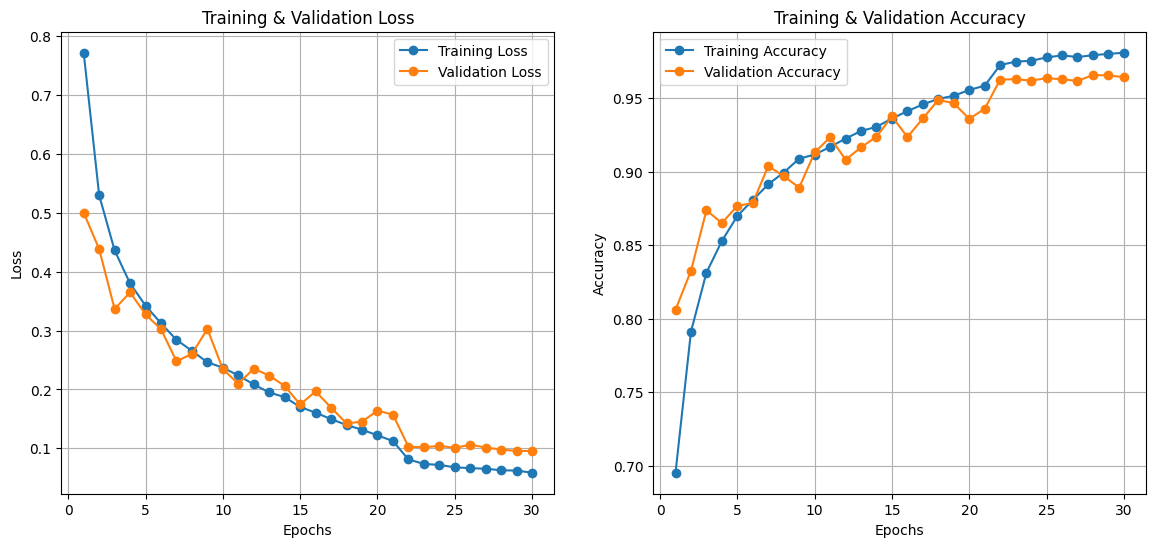

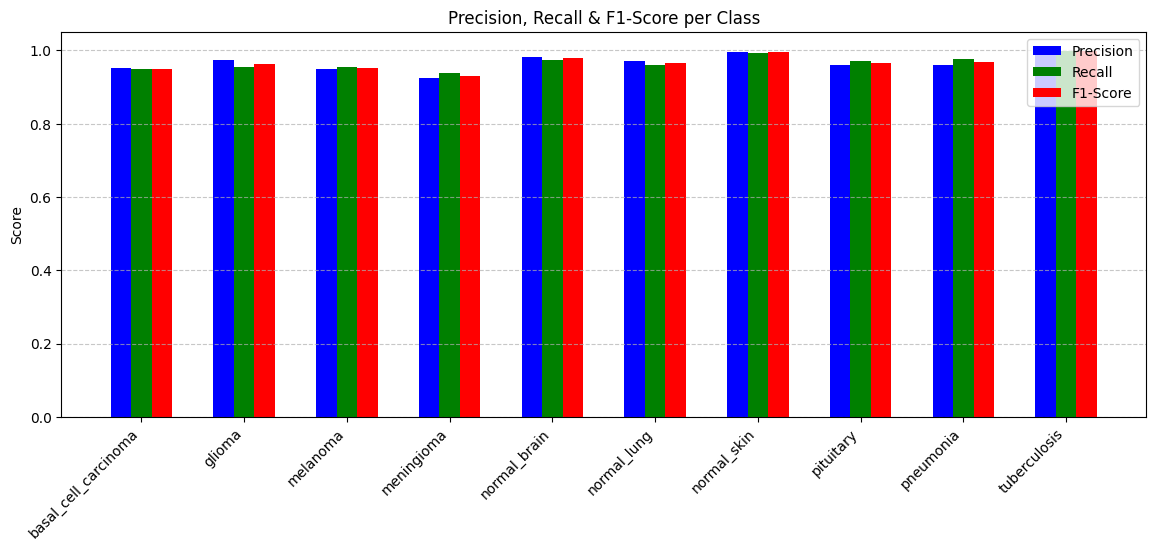

In [ ]:
# Fungsi untuk plot Loss & Accuracy
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label="Training Loss", marker='o')
    plt.plot(epochs, history.history['val_loss'], label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label="Training Accuracy", marker='o')
    plt.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid()

# Fungsi untuk plot Precision, Recall, dan F1-Score
def plot_metrics(y_true, y_pred, class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    x = np.arange(len(class_names))

    plt.figure(figsize=(14, 5))

    # Precision, Recall, F1-Score
    plt.bar(x - 0.2, precision, width=0.2, label="Precision", color="blue")
    plt.bar(x, recall, width=0.2, label="Recall", color="green")
    plt.bar(x + 0.2, f1, width=0.2, label="F1-Score", color="red")

    plt.xticks(ticks=x, labels=class_names, rotation=45, ha='right')
    plt.ylabel("Score")
    plt.title("Precision, Recall & F1-Score per Class")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()

# Panggil fungsi dengan data dari training history
plot_training_history(history)

# Panggil fungsi dengan data dari confusion matrix
plot_metrics(y_true, y_pred, list(val_generator.class_indices.keys()))

### Confussion Matrix

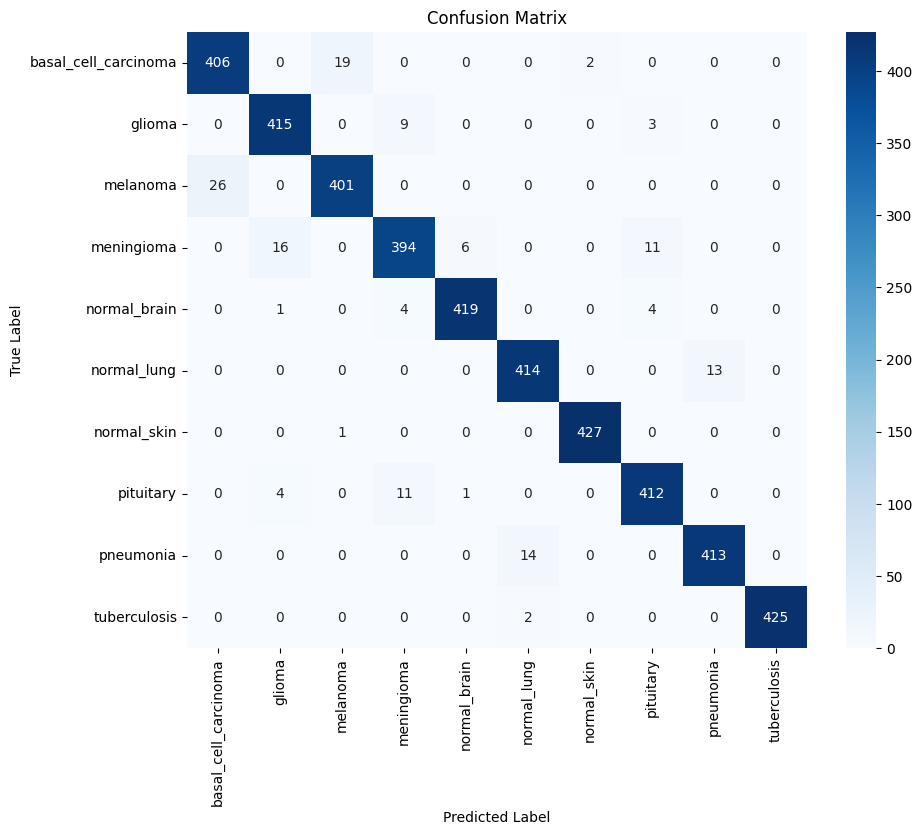

In [ ]:
cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## **Export Model**

In [ ]:
# save model dalam pb, tfjs dan tflite
model.export("saved_model/multidisease_model")  # Simpan dalam format SavedModel

# Simpan model dalam format TensorFlow.js
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/multidisease_model")
tflite_model = converter.convert()

# Buat folder 'tflite' jika belum ada
os.makedirs("tflite", exist_ok=True)

# Simpan model ke file
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at 'saved_model/multidisease_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140684548585104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564232176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564218448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564233408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564231296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564230416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564225488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684564226896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684569730336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140684569732800: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

W0000 00:00:1743677113.131024    8276 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1743677113.131156    8276 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-03 18:45:13.148510: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model/multidisease_model
2025-04-03 18:45:13.162494: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-03 18:45:13.162541: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: saved_model/multidisease_model
I0000 00:00:1743677113.235601    8276 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-03 18:45:13.260000: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-03 18:45:13.551485: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: saved_model/multidisease_model
2025-04-03 18:45:13.622356: I tensorflow

In [ ]:
# Simpan model dalam format TensorFlow.js
! tensorflowjs_converter --input_format=tf_saved_model saved_model/multidisease_model tfjs_model

2025-04-03 18:49:13.173817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743677353.207641   47361 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743677353.219320   47361 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743677353.241331   47361 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743677353.241408   47361 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743677353.241417   47361 computation_placer.cc:177] computation placer alr

## **Inference with model**

### Inference Saved Model

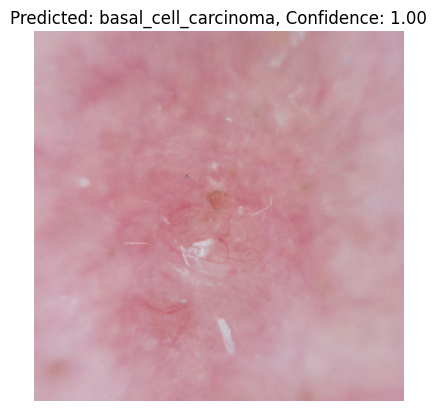

✅ Predicted class: basal_cell_carcinoma, Confidence: 1.00


In [ ]:
# Fungsi untuk memuat gambar dan melakukan preprocessing
def preprocess_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalisasi
    img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension
    return img

# Load model dari format SavedModel
model_path = "saved_model/multidisease_model"
exported_model = tf.saved_model.load(model_path)
infer = exported_model.signatures["serving_default"]

def predict_image(image_path, class_indices):
    test_img = preprocess_image(image_path)
    output_pb = infer(keras_tensor=tf.convert_to_tensor(test_img, dtype=tf.float32))

    # Ambil prediksi kelas dengan confidence tertinggi
    output_probs = output_pb["output_0"].numpy()[0]
    predicted_class_idx = np.argmax(output_probs)
    predicted_label = list(class_indices.keys())[predicted_class_idx]
    confidence = output_probs[predicted_class_idx]

    # Tampilkan hasil prediksi
    plt.imshow(test_img[0])
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()

    return predicted_label, confidence

# Contoh penggunaan
image_path = "dataset/skin_cancer/test/basal_cell_carcinoma/ISIC_0055895.jpg"
class_indices = test_generator.class_indices  # Pastikan ini sudah didefinisikan
predicted_label, confidence = predict_image(image_path, class_indices)
print(f"✅ Predicted class: {predicted_label}, Confidence: {confidence:.2f}")

### Inference TF-Lite Model

In [ ]:
# Fungsi untuk memuat gambar dan melakukan preprocessing
def preprocess_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalisasi
    img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension
    return img

# Load model dari format TF-Lite
tflite_model_path = "tflite/model.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Dapatkan indeks input & output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_image(image_path, class_indices):
    test_img = preprocess_image(image_path)

    # Set input ke model
    interpreter.set_tensor(input_details[0]["index"], test_img.astype(np.float32))

    # Jalankan inferensi
    interpreter.invoke()

    # Ambil hasil output
    output_probs = interpreter.get_tensor(output_details[0]["index"])[0]  # Sudah NumPy array

    # Ambil prediksi kelas dengan confidence tertinggi
    predicted_class_idx = np.argmax(output_probs)
    predicted_label = list(class_indices.keys())[predicted_class_idx]
    confidence = output_probs[predicted_class_idx]

    # Tampilkan hasil prediksi
    plt.imshow(test_img[0])
    plt.title(f"Predicted: {predicted_label}, Confidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()

    return predicted_label, confidence

# Contoh penggunaan
image_path = "dataset/brain_tumor/test/pituitary/Te-pi_0274.jpg"
class_indices = test_generator.class_indices  # Pastikan ini sudah didefinisikan
predicted_label, confidence = predict_image(image_path, class_indices)
print(f"✅ Predicted class: {predicted_label}, Confidence: {confidence:.2f}")

✅ Predicted class: pituitary, Confidence: 1.00
